<a href="https://colab.research.google.com/github/AmirOfir/Cats_and_dogs/blob/master/Identify_dog_or_cat_Make_mosaics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make mosaics

In [2]:
import sys
import numpy as np
import torch
import torchvision
import torch.nn as nn

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torch.autograd import Function
from torchvision import transforms, datasets
import math

import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import copy
import tqdm
from PIL import Image

# Load the data (extract)
import os
import zipfile
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if not (os.path.exists('tmp/train')):
  local_zip = '/content/drive/My Drive/datasets/dogscats/train.zip'
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp')
  zip_ref.close()
  local_zip = '/content/drive/My Drive/datasets/dogscats/test.zip'
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp')
  zip_ref.close()

base_dir = '/tmp'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test1')

train_fnames = os.listdir(train_dir)
validation_fnames = os.listdir(validation_dir)

train_cat_fnames = [os.path.join(train_dir, x) for x in train_fnames if x.startswith('cat')][:-500]
train_dog_fnames = [os.path.join(train_dir, x) for x in train_fnames if x.startswith('dog')][:-500]
validation_cat_fnames = [os.path.join(train_dir, x) for x in train_fnames if x.startswith('cat')][-500:]
validation_dog_fnames = [os.path.join(train_dir, x) for x in train_fnames if x.startswith('dog')][-500:]

print('total training cat images:', len(train_cat_fnames))
print('total training dog images:', len(train_dog_fnames))
print('total validation cat images:', len(validation_cat_fnames))
print('total validation dog images:', len(validation_dog_fnames))

total training cat images: 12000
total training dog images: 12000
total validation cat images: 500
total validation dog images: 500


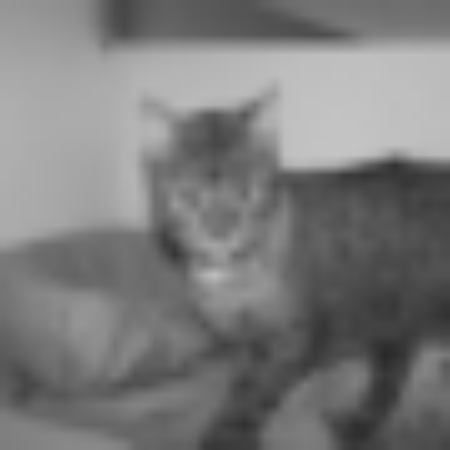

[[0.5803922  0.5803922  0.5803922  0.5803922  0.5803922  0.5803922
  0.5803922  0.5803922  0.5803922  0.5803922  0.5764706  0.5764706
  0.5764706  0.5764706  0.5764706 ]
 [0.5803922  0.5803922  0.5803922  0.5803922  0.5803922  0.5803922
  0.5803922  0.5803922  0.5803922  0.5803922  0.5764706  0.5764706
  0.5764706  0.5764706  0.5764706 ]
 [0.5803922  0.5803922  0.5803922  0.5803922  0.5803922  0.5803922
  0.5803922  0.5803922  0.5803922  0.5803922  0.5764706  0.5764706
  0.5764706  0.5764706  0.5764706 ]
 [0.5803922  0.5803922  0.5803922  0.5803922  0.5803922  0.5803922
  0.5803922  0.5803922  0.5803922  0.5803922  0.5764706  0.5764706
  0.5764706  0.5764706  0.5764706 ]
 [0.5803922  0.5803922  0.5803922  0.5803922  0.5803922  0.5803922
  0.5803922  0.5803922  0.5803922  0.5803922  0.5764706  0.5764706
  0.5764706  0.5764706  0.5764706 ]
 [0.5803922  0.5803922  0.5803922  0.5803922  0.5803922  0.5803922
  0.5803922  0.5803922  0.5803922  0.5803922  0.5764706  0.5764706
  0.5764706  0.5

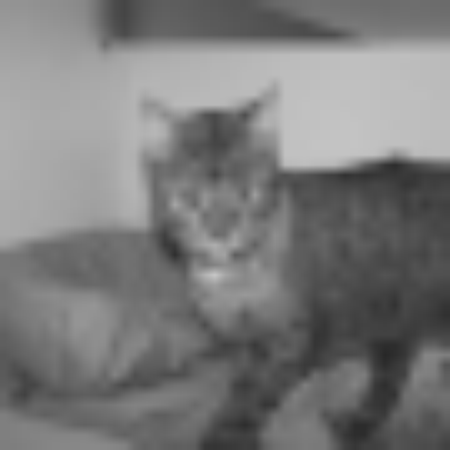

tensor(0.0019)

In [37]:
from google.colab.patches import cv2_imshow
ex_size = 450
mosaic_size = 10
img = Image.open(train_cat_fnames[1])
img = transforms.functional.to_grayscale(img)
img = transforms.functional.resize(img, (int(ex_size/mosaic_size),int(ex_size/mosaic_size)))
img = transforms.functional.resize(img, (ex_size,ex_size))
img = transforms.functional.to_tensor(img)
cv2_imshow(img.numpy()[0]*255)
img1 = img

img = Image.open(train_cat_fnames[1])
img = transforms.functional.to_grayscale(img)
img = transforms.functional.resize(img, (ex_size,ex_size))
img = transforms.functional.to_tensor(img)
img = F.avg_pool2d(img, mosaic_size)
img = transforms.functional.to_pil_image(img, mode='L')
img = transforms.functional.resize(img, (ex_size,ex_size))
img = transforms.functional.to_tensor(img)
np.set_printoptions(threshold=sys.maxsize)

print(img.numpy()[0,0:15,0:15])

cv2_imshow(img.numpy()[0]*255)

torch.mean(img1-img)

In [0]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = train_cat_fnames[pic_index-8:pic_index]
next_dog_pix = train_dog_fnames[pic_index-8:pic_index]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [0]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, label=-1, mode='train', transform = None):
        self.file_list = file_list
        self.label = label
        self.mode = mode
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(self.file_list[idx])
        if self.transform:
            img = self.transform(img)
            
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.label #file_list[idx]
        
required_size = 450        
data_transform = transforms.Compose([
    transforms.Resize((45,45)),
    transforms.Resize((450,450)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_cats_ds = CatDogDataset(train_cat_fnames, 0, transform = data_transform)
train_dogs_ds = CatDogDataset(train_dog_fnames, 1, transform = data_transform)

train_catdogs_ds = ConcatDataset([train_cats_ds, train_dogs_ds])
dataloader = DataLoader(train_catdogs_ds, batch_size = 32, shuffle=False, num_workers=4)

validation_cats = CatDogDataset(validation_cat_fnames, 0, transform = data_transform)
validation_dogs = CatDogDataset(validation_dog_fnames, 1, transform = data_transform)

validation_catdogs = ConcatDataset([validation_cats, validation_dogs])
validation_size = len(validation_cat_fnames) + len(validation_dog_fnames)
validation_dataloader = DataLoader(validation_catdogs, batch_size = int(validation_size / 100), shuffle=False, num_workers=4)

torch.Size([10, 1, 450, 450])
(3, 906, 3618)


IndexError: ignored

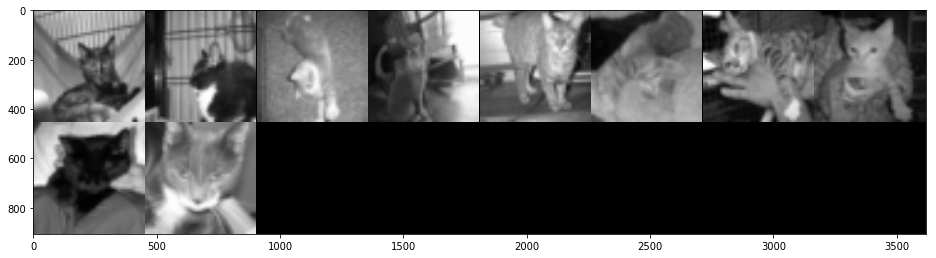

In [42]:
samples, labels = iter(validation_dataloader).next()
print(samples.shape)
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
print(np_grid_imgs.shape)
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

img = samples[11].numpy()
cv2_imshow(img[0]*255)


In [0]:
kernel = torch.randn(1,1,4,4)
print(samples.shape)
out = F.conv2d(samples, kernel,padding=1); print(out.shape)
out = F.max_pool2d(out, 2, 2); print(out.shape)
out = F.conv2d(out, kernel,padding=1); print(out.shape)
out = F.max_pool2d(out, 2, 2); print(out.shape)
out = F.conv2d(out, kernel,padding=1); print(out.shape)
out = F.max_pool2d(out, 2, 2); print(out.shape)
out = F.conv2d(out, kernel,padding=1); print(out.shape)
out = F.max_pool2d(out, 2, 2); print(out.shape)
out = F.conv2d(out, kernel,padding=1); print(out.shape)
out = F.max_pool2d(out, 2, 2); print(out.shape, 'end') #torch.Size([32, 1, 13, 13]) end
out = F.conv2d(out, kernel); print(out.shape)
out = F.max_pool2d(out, 2, 2); print(out.shape)

kernel = torch.randn(1,1,16,16)
out = F.conv2d(samples, kernel,padding=1); print(out.shape)
out = F.max_pool2d(out, 2, 2); print(out.shape)
out = F.conv2d(out, kernel,padding=1); print(out.shape)
out = F.max_pool2d(out, 2, 2); print(out.shape)
out = F.conv2d(out, kernel,padding=1); print(out.shape)
out = F.max_pool2d(out, 2, 2); print(out.shape)
out = F.conv2d(out, kernel,padding=1); print(out.shape)
out = F.max_pool2d(out, 2, 2); print(out.shape , 'end') #torch.Size([32, 1, 15, 15]) end
out = F.conv2d(out, kernel,padding=1); print(out.shape)
out = F.max_pool2d(out, 2, 2); print(out.shape)
out = F.conv2d(out, kernel,padding=1); print(out.shape)
out = F.max_pool2d(out, 2, 2); print(out.shape)

In [0]:
device = 'cuda'

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    addition = 10

    self.cl1 = nn.Conv2d(1,addition,4,1,padding=1)
    self.cl2 = nn.Conv2d(addition,addition*2, 4,1,padding=1)
    addition *=2
    self.cl3 = nn.Conv2d(addition,addition*2, 4,1,padding=1)
    addition *=2
    self.cl4 = nn.Conv2d(addition,addition*2, 4,1,padding=1)
    addition *=2
    self.cl5 = nn.Conv2d(addition,addition*2, 4,1,padding=1) #torch.Size([32, 140, 13, 13]) end
    addition *=2
    self.fc1 = nn.Linear( addition * (13**2), 500)
    self.fc2 = nn.Linear(500, 10)
  def forward(self, x): 
    x = F.relu(self.cl1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.cl2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.cl3(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.cl4(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.cl5(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, self.fc1.in_features)
    x = F.relu(self.fc1(x)) # new size is batch x 500
    x = self.fc2(x) # new size is batch x 10
    x = F.log_softmax(x, dim=1) # used dim=1 to work on the data not on the batch
    return x
model = Net().to(device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

In [0]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in validation_dataloader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(validation_dataloader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(validation_dataloader.dataset),
      100. * correct / len(validation_dataloader.dataset)))
  return 100. * correct / len(validation_dataloader.dataset)

In [0]:
epochs = 15
itr = 1
p_itr = 10
model.train()
total_loss = 0
loss_list = []
acc_list = []
for epoch in range(epochs):
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()
        
        if itr%p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
            
        itr += 1
    acc = test()
    if (acc > 80):
      break
print(itr)
plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

[Epoch 1/15] Iteration 10 -> Train Loss: 1.1825, Accuracy: 0.531
[Epoch 1/15] Iteration 20 -> Train Loss: 0.6978, Accuracy: 0.562
[Epoch 1/15] Iteration 30 -> Train Loss: 0.7256, Accuracy: 0.562
[Epoch 1/15] Iteration 40 -> Train Loss: 0.6861, Accuracy: 0.531
[Epoch 1/15] Iteration 50 -> Train Loss: 0.6944, Accuracy: 0.531
[Epoch 1/15] Iteration 60 -> Train Loss: 0.6945, Accuracy: 0.562
[Epoch 1/15] Iteration 70 -> Train Loss: 0.7024, Accuracy: 0.469
[Epoch 1/15] Iteration 80 -> Train Loss: 0.6990, Accuracy: 0.594
[Epoch 1/15] Iteration 90 -> Train Loss: 0.7123, Accuracy: 0.500
[Epoch 1/15] Iteration 100 -> Train Loss: 0.7047, Accuracy: 0.594
[Epoch 1/15] Iteration 110 -> Train Loss: 0.6994, Accuracy: 0.344
[Epoch 1/15] Iteration 120 -> Train Loss: 0.6979, Accuracy: 0.469
[Epoch 1/15] Iteration 130 -> Train Loss: 0.7012, Accuracy: 0.562
[Epoch 1/15] Iteration 140 -> Train Loss: 0.7050, Accuracy: 0.531
[Epoch 1/15] Iteration 150 -> Train Loss: 0.6984, Accuracy: 0.531
[Epoch 1/15] Iterat